# Image classification with [Qiskit](https://qiskit.org/documentation/stable/0.19/index.html)


Image classification is a computer vision task that involves categorizing images into predefined classes or categories. The goal is to develop algorithms or models that can accurately identify and assign labels to images based on their visual features and content. This task is commonly used in various applications, such as object recognition, facial recognition, medical imaging, and autonomous driving, to enable machines to understand and interpret visual information in a similar way to humans. The output of an image classification task is a prediction or probability distribution indicating the likelihood of each class for a given image.


This notebook is inspired by [the Qiskit Machine Learning tutorial](https://qiskit.org/ecosystem/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings


from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


$ $

## Generating image data 

Each image is made of either vertical strips (class 1) or of horizontal strips (class 0).
Each image is a binary matrix of $\text{size}\times \text{size}$ and is flatted to create a datapoint x.
An image with horizontal strips is the transposition of an image with vertical strips and vice versa.

__Here the machine learning task is to classify these two kinds of images.__

In [2]:
size = 4                            # size of image

binaries = np.array([[int(i) for i in np.binary_repr(a, size)] for a in range(1, 2**size - 1)]) 


#--------------------------------------------------------------------------------------------------

ones = np.ones((size, size))

X = []                              # X collects (size x size) feature matrices
y = []                              # y collects class labels 1 or 0

for b in binaries:
    x = b*ones
    
    X.append(x.flatten())           # image with vertical strips, class 1
    y.append(1)
    
    X.append((x.T).flatten())       # image with horizontal strips, class 0  
    y.append(0)

X, y = np.array(X), np.array(y)

#--------------------------------------------------------------------------------------------------    


num_examples, num_features = X.shape
print(f'number of examples = {num_examples}')    
print(f'number of features = {num_features}')    

num_features == size*size

number of examples = 28
number of features = 16


True

## view an example:


x_6 of size (4, 4) :


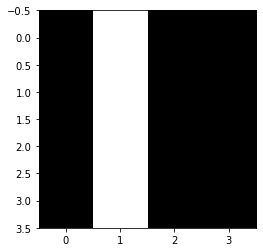

true label = y = 1 = image of vertical strips 



In [3]:
idx = np.random.choice(num_examples)

x = X[idx].reshape(size,size)
print(f'x_{idx} of size {x.shape} :')
plt.imshow(x, cmap='gray', vmin=0, vmax=1)
plt.show()

if y[idx]==1:
    class_ = 'vertical'
elif y[idx]==0:
    class_ = 'horizontal'

print(f'true label = y = {y[idx]} = image of {class_} strips \n')


## train and test split of the dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


num_train_examples, num_test_examples = X_train.shape[0], X_test.shape[0]
print(f'number of train examples = {num_train_examples}')    
print(f'number of test examples = {num_test_examples}\n') 


print(f'number of features = {num_features}')

num_train_examples + num_test_examples == num_examples

number of train examples = 16
number of test examples = 12

number of features = 16


True

$ $

# Quantum Machine Learning

use either angle or amplitude feature encoding.
__When the number of features is large, use amplitude encoding.__

## (1a) Feature Map (FM): angle encoding

In [5]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

'For angle encoding, num_qubits = num_features'


#fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z']) 
fm = ZZFeatureMap(feature_dimension=num_features, reps=1) 

fm.decompose().draw() 


┌───┐┌─────────────┐                                                »
 q_0: ┤ H ├┤ P(2.0*x[0]) ├───■────────────────────────────────────■────■──»
      ├───┤├─────────────┤ ┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
 q_1: ┤ H ├┤ P(2.0*x[1]) ├─┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
      ├───┤├─────────────┤ └───┘└──────────────────────────────┘└───┘┌─┴─┐»
 q_2: ┤ H ├┤ P(2.0*x[2]) ├───────────────────────────────────────────┤ X ├»
      ├───┤├─────────────┤                                           └───┘»
 q_3: ┤ H ├┤ P(2.0*x[3]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_4: ┤ H ├┤ P(2.0*x[4]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_5: ┤ H ├┤ P(2.0*x[5]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_6: ┤ H ├┤ P(2.0*x[6]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_7: ┤ H ├┤ P(2.0*x[7]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_8: ┤ H ├┤ P(2.0*x[8]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┤                                                »
 q_9: ┤ H ├┤ P(2.0*x[9]) ├────────────────────────────────────────────────»
      ├───┤├─────────────┴┐                                               »
q_10: ┤ H ├┤ P(2.0*x[10]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_11: ┤ H ├┤ P(2.0*x[11]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_12: ┤ H ├┤ P(2.0*x[12]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_13: ┤ H ├┤ P(2.0*x[13]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_14: ┤ H ├┤ P(2.0*x[14]) ├───────────────────────────────────────────────»
      ├───┤├──────────────┤                                               »
q_15: ┤ H ├┤ P(2.0*x[15]) ├───────────────────────────────────────────────»
      └───┘└──────────────┘                                               »
«                                                     »
« q_0: ──────────────────────────────────■─────────■──»
«                                        │         │  »
« q_1: ──────────────────────────────────┼────■────┼──»
«      ┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  »
« q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──»
«      └──────────────────────────────┘└───┘└───┘┌─┴─┐»
« q_3: ──────────────────────────────────────────┤ X ├»
«                                                └───┘»
« q_4: ───────────────────────────────────────────────»
«                                                     »
« q_5: ───────────────────────────────────────────────»
«                                                     »
« q_6: ───────────────────────────────────────────────»
«                                                     »
« q_7: ───────────────────────────────────────────────»
«                                                     »
« q_8: ───────────────────────────────────────────────»
«                                                     »
« q_9: ───────────────────────────────────────────────»
«                                                     »
«q_10: ───────────────────────────────────────────────»
«                                                     »
«q_11: ───────────────────────────────────────────────»
«                                                     »
«q_12: ───────────────────────────────────────────────»
«                                         

## (1b) Feature Map (FM): [amplitude encoding](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.circuit.library.RawFeatureVector.html)


In [ ]:
from qiskit_machine_learning.circuit.library import RawFeatureVector

'For amplitude encoding, num_qubits = n = np.log2(num_features)''

fm = RawFeatureVector(feature_dimension=n) 
fm.draw() 


## (2) Parameterized Quantum Circuit (PQC) = Quantum Neural Network (QNN)

In [6]:
from qiskit.circuit.library import RealAmplitudes


'''
For angle encoding, num_qubits = num_features
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=num_features, reps=3)
pqc.decompose().draw()


┌──────────┐                                                         »
 q_0: ─┤ Ry(θ[0]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_1: ─┤ Ry(θ[1]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_2: ─┤ Ry(θ[2]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_3: ─┤ Ry(θ[3]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_4: ─┤ Ry(θ[4]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_5: ─┤ Ry(θ[5]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_6: ─┤ Ry(θ[6]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_7: ─┤ Ry(θ[7]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_8: ─┤ Ry(θ[8]) ├─────────────────────────────────────────────────────────»
       ├──────────┤                                                         »
 q_9: ─┤ Ry(θ[9]) ├─────────────────────────────────────────────────────────»
      ┌┴──────────┤                                                         »
q_10: ┤ Ry(θ[10]) ├──────────────────────────────────────────────────■──────»
      ├───────────┤                                                ┌─┴─┐    »
q_11: ┤ Ry(θ[11]) ├─────────────────────────────────────■──────────┤ X ├────»
      ├───────────┤                                   ┌─┴─┐    ┌───┴───┴───┐»
q_12: ┤ Ry(θ[12]) ├────────────────────────■──────────┤ X ├────┤ Ry(θ[28]) ├»
      ├───────────┤                      ┌─┴─┐    ┌───┴───┴───┐└───────────┘»
q_13: ┤ Ry(θ[13]) ├───────────■──────────┤ X ├────┤ Ry(θ[29]) ├──────■──────»
      ├───────────┤         ┌─┴─┐    ┌───┴───┴───┐└───────────┘    ┌─┴─┐    »
q_14: ┤ Ry(θ[14]) ├──■──────┤ X ├────┤ Ry(θ[30]) ├──────■──────────┤ X ├────»
      ├───────────┤┌─┴─┐┌───┴───┴───┐└───────────┘    ┌─┴─┐    ┌───┴───┴───┐»
q_15: ┤ Ry(θ[15]) ├┤ X ├┤ Ry(θ[31]) ├─────────────────┤ X ├────┤ Ry(θ[47]) ├»
      └───────────┘└───┘└───────────┘                 └───┘    └───────────┘»
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_5: ──────────────────────────────────────────────────────────■──────»
«                                                              ┌─┴─┐    »
« q_6: ─────────────────────────────────────────────■──────────┤ X ├────»
«                                                 ┌─┴─┐    ┌───┴───┴───┐»
« q_7: ────────────────────────────────■──────────┤ X ├────┤ Ry(θ[23]) ├»
«                                    ┌─┴─┐    ┌───┴───┴───┐└───────────┘»
« q_8: ───────────────────■──────────┤ X ├────┤ Ry(θ[24]) ├──────■──────»
«                       ┌─┴─┐    ┌───┴───┴───┐└───────────┘    ┌─┴─┐    »
« q_9: ──────■──────────┤ X

$ $

## (3) Build the model: [Variational Quantum Classifier (VQC)](https://qiskit.org/documentation/stable/0.19/stubs/qiskit.aqua.algorithms.VQC.html#qiskit.aqua.algorithms.VQC) with FM and PQC


__[Sampler](https://qiskit.org/documentation/apidoc/primitives.html) class calculates probabilities or quasi-probabilities of bitstrings from quantum circuits.__
A sampler is initialized with an empty parameter set. The sampler is used to create a JobV1, via the qiskit.primitives.Sampler.run() method, and yields a SamplerResult object, which contains probabilities or quasi-probabilities of bitstrings, plus optional metadata like error bars in the samples.

$ $


In [7]:
from qiskit.algorithms.optimizers import COBYLA

# This defines where to train our classifier: on a simulator or a real quantum computer
from qiskit.primitives import Sampler                             # here we have chosen a simulator 

from qiskit_machine_learning.algorithms.classifiers import VQC    # !pip install qiskit[machine-learning]


#------------------------------------------------------------------------------------------------

optimizer = COBYLA(maxiter=60)                 # maxiter = Maximum number of iterations (function evaluations)
sampler = Sampler()

#------------------------------------------------------------------------------------------------

from IPython.display import clear_output
objective_func_vals = []

                                    # a callback that can access the intermediate data during the optimization
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#------------------------------------------------------------------------------------------------

vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## (4) Training VQC ...

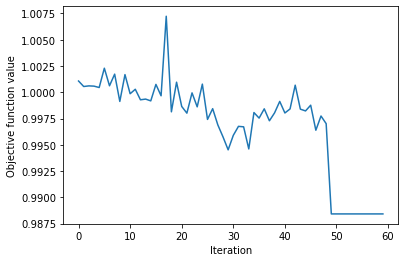

CPU times: user 41min 16s, sys: 34min 46s, total: 1h 16min 2s
Wall time: 33min 58s


In [8]:
%%time

'''Training time seems to increase with the number of features, examples, and learnable-parameters'''

vqc.fit(X_train, y_train)

## (5) performance evaluation of trained VQC



In [9]:
%%time

def performance_VQC(X, y, name):
    y_pred = vqc.predict(X)
    print(classification_report(y, y_pred))
    print(f'{confusion_matrix(y, y_pred)} = confusion matrix for {name} set \n')
    return y_pred
    

y_pred_train = performance_VQC(X_train, y_train, 'train')
y_pred_test = performance_VQC(X_test, y_test, 'test')


              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.80      0.50      0.62         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16

[[7 1]
 [4 4]] = confusion matrix for train set 

              precision    recall  f1-score   support

           0       0.44      0.67      0.53         6
           1       0.33      0.17      0.22         6

    accuracy                           0.42        12
   macro avg       0.39      0.42      0.38        12
weighted avg       0.39      0.42      0.38        12

[[4 2]
 [5 1]] = confusion matrix for test set 

CPU times: user 1min 11s, sys: 59.2 s, total: 2min 10s
Wall time: 57.7 s


### predict test examples

x of size (4, 4) :


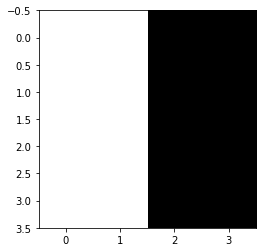

true label = y = 0 = image with horizontal strips 

predicted label = 0



In [14]:
idx = np.random.choice(len(X_test))

x = X_test[idx]
print(f'x of size {(size,size)} :')
plt.imshow(x.reshape(size,size), cmap='gray')
plt.show()

if y[idx]==1:
    class_ = 'vertical'
elif y[idx]==0:
    class_ = 'horizontal'

print(f'true label = y = {y[idx]} = image with {class_} strips \n')


y_pred_ = vqc.predict(x)
print(f'predicted label = {y_pred_}\n')


$ $

$ $

# Classical Machine Learning (ML) models with [scikit-learn](https://scikit-learn.org/stable/)

In [11]:
%%time
warnings.filterwarnings('ignore')

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train)                         # fit model on train set
    
    y_train_pred = ML_model.predict(X_train)               # predict with the trained model
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train, y_train))         # evaluate model performance 
    print(confusion_matrix(y_train, y_train_pred), "= confusion matrix for train set \n")

    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n")
    
    print(70*'=')
    

#----------------------------------------------------------------------------------

print(70*'=')
ML_model = linear_model.LogisticRegression()                # create model instance
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


                     LogisticRegression() 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

[[6 2]
 [2 6]] = confusion matrix for train set 

              precision    recall  f1-score   support

           0       0.17      0.17      0.17         6
           1       0.17      0.17      0.17         6

    accuracy                           0.17        12
   macro avg       0.17      0.17      0.17        12
weighted avg       0.17      0.17      0.17        12

[[1 5]
 [5 1]] = confusion matrix for test set 

                     MLPClassifier() 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8



# $ $




$ $

## I have also performed Image Classification using CNNs and QNNs built on PyTorch [see [the repositary](https://github.com/ArunSehrawat/Image_classification_with_CNN_and_QNN)].

$ $